In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
from chroma_server.db.duckdb import DuckDB
from chroma_server.index.hnswlib import Hnswlib
import numpy as np


In [2]:
db = DuckDB
# ann_index = Hnswlib

# init db and index
db = db()
# ann_index = ann_index()

In [3]:
# Load the database and the index
db.load(path="chroma-server/.chroma/chroma.parquet")
# ann_index.load(db.count(), len(db.fetch(limit=1).embedding_data),path="chroma-server/.chroma/index.bin")



In [4]:
training_data = db.fetch(where_filter={"dataset":"waymo-phx-train"})
validation_data = db.fetch(where_filter={"dataset":"waymo-phx-val"})

In [ ]:
def compute_confusion(dataset):
    # Compute the confusion matrix between label_category_name and inference_category_name for the training data
    confusion_matrix = {}
    for index, row in dataset.iterrows():
        if row.label_category_name not in confusion_matrix:
            confusion_matrix[row.label_category_name] = {}
        if row.inference_category_name not in confusion_matrix[row.label_category_name]:
            confusion_matrix[row.label_category_name][row.inference_category_name] = 0
        confusion_matrix[row.label_category_name][row.inference_category_name] += 1

    # Compute the confusion proportions
    confusion_proportions = {}
    for label in confusion_matrix:
        confusion_proportions[label] = {}
        total = sum(confusion_matrix[label].values())
        for inference in confusion_matrix[label]:
            confusion_proportions[label][inference] = confusion_matrix[label][inference] / total

    # Pretty print the confusion proportions in a to three decimal places, and the totals per label
    for label in confusion_proportions:
        print(label)
        for inference in confusion_proportions[label]:
            print(f"\t{inference}: {confusion_proportions[label][inference]:.3f}")
        print(f"\tTotal: {sum(confusion_matrix[label].values()):.3f}")

print("Training Data")
compute_confusion(training_data)
print("Validation Data")
compute_confusion(validation_data)

In [ ]:
import numpy as np

# Turn the embeddings into a numpy array
embeddings = np.array(training_data["embedding_data"].tolist())
class_embeddings = embeddings[:,5:]
inference_categories = np.array(training_data["inference_category_name"].tolist())
label_categories = np.array(training_data["label_category_name"].tolist())
label_categories = np.where(label_categories == None, "None", label_categories)


subsample = 100
subsampled_embeddings = class_embeddings[::subsample]
subsampled_inference_categories = inference_categories[::subsample]
subsampled_label_categories = label_categories[::subsample]

# Replace None with "None" in labele categories
subsampled_label_categories = np.where(subsampled_label_categories == None, "None", subsampled_label_categories)

# Compute the sigmoid of the subsampled embeddings
sigmoid_embeddings = 1 / (1 + np.exp(-subsampled_embeddings))

In [ ]:
import plotly.express as px
fig = px.scatter_3d(x=subsampled_embeddings[:,1], y=subsampled_embeddings[:,2], z=subsampled_embeddings[:,4], color=subsampled_label_categories, width=1000, height=1000)

# Use a dark theme
fig.update_layout(template="plotly_dark")

# Highlight the points that are not None
fig.update_traces(marker=dict(size=3, line=dict(width=1, color='DarkSlateGrey')), selector=dict(mode='markers'))

# Make the axes equal
fig.update_layout(scene_aspectmode="data")

fig.show()

In [ ]:
import umap
import umap.plot

# Get UMAP of a subsample of the embeddings
u_subsample = 100
reducer = umap.UMAP()
umap_embeddings = reducer.fit_transform(embeddings[::u_subsample])

In [ ]:
# Plot the UMAP embeddings
umap.plot.points(reducer, labels=label_categories[::u_subsample], theme="fire")

# ANN Testing

In [5]:
# Create an ANN indedx from the training set, where the label matches the inference category
filtered_training_data = training_data[training_data.label_category_name == training_data.inference_category_name]
# filtered_training_data["embedding_data"] = filtered_training_data["embedding_data"].apply(lambda x: np.array(x)[5:])

ann_index = Hnswlib
ann_index = ann_index()
ann_index.run(filtered_training_data)



# Compute the index with cosine similarity  
# ann_index.run(db.fetch(), space="cosine")

In [6]:
# Get ids for embeddings in the training dataset
training_ids = filtered_training_data["id"].tolist()

# Get embeddings for the validation dataset
# validation_data = db.fetch(where_filter={"dataset":"waymo-phx-val"})
validation_embs = np.array(validation_data["embedding_data"].tolist())
# validation_class_embs = validation_embs[:,5:]

In [17]:
n_neighbors = 1000
neighbors = ann_index.get_nearest_neighbors(validation_embs, n_neighbors)

In [18]:
dists = np.array(neighbors[1])
mean_dists = np.mean(dists, axis=1)
max(mean_dists)
np.average(mean_dists)

0.70384276

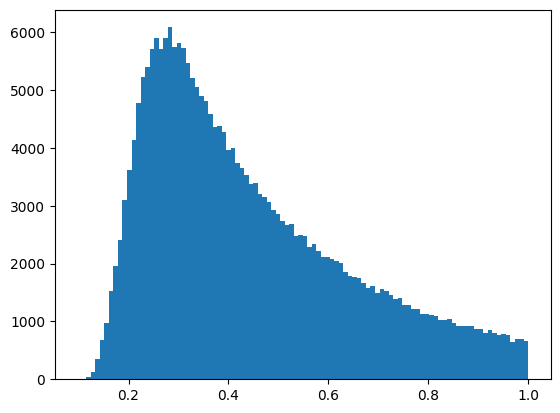

In [20]:
# Display a histogram of mean_dists, rejecting outliers
import matplotlib.pyplot as plt
plt.hist(mean_dists[mean_dists < 1], bins=100)
plt.show()

In [21]:
neighbor_ids = np.array(neighbors[0])
flat_ids = neighbor_ids.reshape(-1) - 1

flat_categories = training_data.iloc[flat_ids]["label_category_name"].to_numpy()

# Reshape the categories to match the shape of the neighbors
categories = flat_categories.reshape(neighbor_ids.shape)

validation_inference_categories = validation_data["inference_category_name"].to_numpy()

matches = np.array([categories[i,:] == v_cat for i, v_cat in enumerate(validation_inference_categories)])

# Get the proportion of matches for each neighbor
match_proportions = np.sum(matches, axis=1) / matches.shape[1]

(648,)

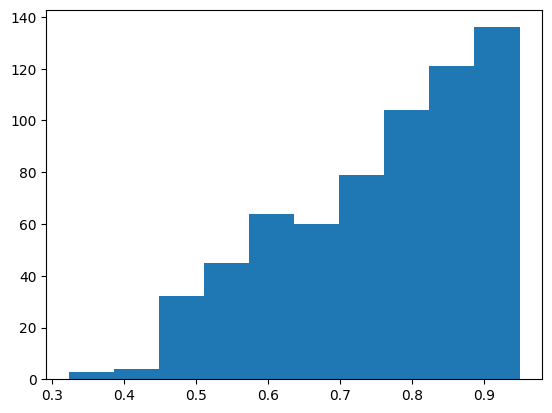

In [22]:
# Show a histogram of match proportions
plt.hist(match_proportions[match_proportions < 0.95], bins=10)

match_proportions[match_proportions < 0.95].shape

In [ ]:
selected = validation_data.iloc[match_proportions < 0.95]
total_selected_confused = len(match_proportions < 0.95)
proportion_selected_confused = 1 - np.sum(validation_data["label_category_name"][match_proportions < 0.95] == validation_data["inference_category_name"][match_proportions < 0.95]) / np.sum(match_proportions < 0.9)

In [15]:
# Get the validation data where the label category is not None, and is not the same as the inference category
total_confused = validation_data[validation_data.label_category_name != validation_data.inference_category_name]
total_confused_excluding_none = total_confused[~total_confused.label_category_name.isnull()]


In [ ]:
# Write the unique selectefed URIs to a file
with open("confusion_uris.txt", "w") as f:
    for uri in selected["input_uri"].unique():
        f.write(f"{uri}\n")

In [30]:
# Sweep the match_proportion threshold and plot a graph of the proportion of confused samples
thresholds = np.arange(0.0, 0.99, 0.01)
precisions = []
recalls = []
for threshold in thresholds:
    total_selected = np.sum(validation_data["label_category_name"][match_proportions < threshold] == validation_data["inference_category_name"][match_proportions < threshold])
    precision = 1 - total_selected / np.sum(match_proportions < threshold)
    recall = total_selected / len(total_confused)
    precisions.append(precision*100)
    recalls.append(recall*100)

# Plot prorportions and recalls on the same plot but different y axis with a dark theme, and make the chart square
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=thresholds, y=precisions, name="Precision"))
fig.add_trace(go.Scatter(x=thresholds, y=recalls, name="Recall", yaxis="y2"))
fig.update_layout(template="plotly_dark", yaxis2=dict(overlaying='y', side='right'))
fig.update_layout(width=1000, height=1000)
fig.show()

# In a new figure, draw the precision-recall curve
fig = go.Figure()
fig.add_trace(go.Scatter(x=recalls, y=precisions, name="Precision-Recall Curve"))
fig.update_layout(template="plotly_dark")
fig.update_layout(width=1000, height=1000)
fig.show()


/var/folders/18/t_4m3_611wq0wcv0xnpgp0bh0000gn/T/ipykernel_11667/167097215.py:7: RuntimeWarning:

invalid value encountered in long_scalars



In [ ]:
1 - np.sum(validation_data["label_category_name"][match_proportions == 1] == validation_data["inference_category_name"][match_proportions == 1]) / np.sum(match_proportions == 1)